In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

%matplotlib notebook 
from astropy.io import fits
import pickle

import bz2

In [2]:
#Import the light curves
sector01_lcf = fits.open('lightcurve_1.fits')
sector02_lcf = fits.open('lightcurve_2.fits')
sector03_lcf = fits.open('lightcurve_3.fits')

In [3]:
lcf_data = sector03_lcf[1].data

In [4]:
bjd_ref = lcf_data['TIME'] + sector03_lcf[1].header['BJDREFI']
print(bjd_ref)

[2459743.99442937 2459743.99581826 2459743.99720715 ... 2459768.9789415
 2459768.98033037 2459768.98171923]


In [5]:
sap_flux = lcf_data['SAP_FLUX']
sap_flux_err = lcf_data['SAP_FLUX_ERR']

pdcsap_flux = lcf_data['PDCSAP_FLUX']
pdcsap_flux_err = lcf_data['PDCSAP_FLUX_ERR']

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(bjd_ref, sap_flux, c='C0', label='SAP flux', s=2)
plt.scatter(bjd_ref, pdcsap_flux, c='C1', label='PDCSAP flux', s=2)
plt.legend()

plt.xlabel('BJD [d]')
plt.ylabel('Flux [e-/s]')
plt.show()

<IPython.core.display.Javascript object>

In [7]:
print(np.shape(sap_flux))
print(np.shape(pdcsap_flux))

(17992,)
(17992,)


In [8]:
plt.figure()
plt.scatter(bjd_ref, lcf_data['QUALITY'], c='C0', label='QUALITY', s=2)
plt.xlabel('BJD [d]')
plt.show()

<IPython.core.display.Javascript object>

In [9]:
quality_selection = (lcf_data['QUALITY']==0)
np.sum(quality_selection)

15068

In [11]:
np.binary_repr(lcf_data['QUALITY'][3])

'100000'

In [12]:
print('Number of    SAP epochs:', np.shape(sap_flux))
print('Number of PDCSAP epochs:', np.shape(pdcsap_flux))

Number of    SAP epochs: (17992,)
Number of PDCSAP epochs: (17992,)


In [13]:
quality = lcf_data['QUALITY']

bits_to_be_checked = np.array([1,2,3,4,5,6,8,10,12,13,15,16])
value = 0
for v in bits_to_be_checked:
    value = value + 2**(v-1)

print('Value corresponding to the active flags {0:16d}'.format(value))
print('example point                           {0:16d}'.format(quality[3]))
print()
print('binary representation of the selected flag     {0:16d}'.format(int(np.binary_repr(value))))
print('binary representation of the selected example  {0:16d}'.format(int(np.binary_repr(quality[3]))))

# bitwise comparison between the reference value and the quality flag + selection of nan values.
# at least one flag must be positive in order to exclude the point.
bad_data = (np.bitwise_and(quality, value) >= 1) & (np.isnan(pdcsap_flux))

good_data = ~bad_data

# https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview
very_good_data = (lcf_data['QUALITY']==0)

Value corresponding to the active flags            55999
example point                                         32

binary representation of the selected flag     1101101010111111
binary representation of the selected example            100000


<IPython.core.display.Javascript object>


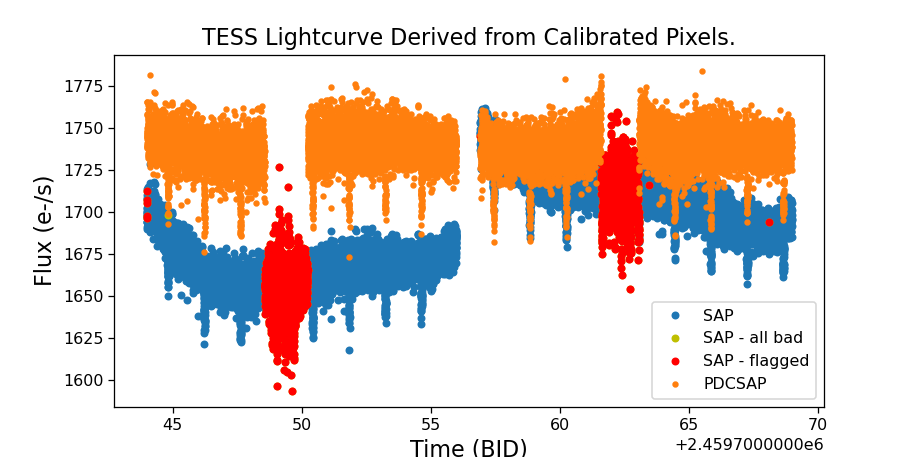

In [14]:
time_bjd = bjd_ref

plt.figure(figsize = (8,4))
plt.plot(time_bjd[good_data], sap_flux[good_data],'.', label = 'SAP', ms = 8)
plt.plot(time_bjd[~very_good_data], sap_flux[~very_good_data],'.', label = 'SAP - all bad', c='y', ms = 8)
plt.plot(time_bjd[bad_data], sap_flux[bad_data],'.', label = 'SAP - flagged', c='r', ms = 8)

plt.plot(time_bjd[good_data], pdcsap_flux[good_data],'.', label = 'PDCSAP', ms = 6)

plt.legend()
plt.xlabel('Time (BJD)', fontsize = 14)
plt.ylabel('Flux (e-/s)', fontsize = 14)
plt.title("TESS Lightcurve Derived from Calibrated Pixels.", fontsize = 14)
plt.show()

In [16]:
fileout = open('target_PDCSAPflux_3.dat', 'w')

for b,v,e in zip(time_bjd[very_good_data], 
                 pdcsap_flux[very_good_data], 
                 pdcsap_flux_err[very_good_data]):
    fileout.write('{0:16f} {1:16f} {2:16f}\n'.format(b,v,e))
fileout.close()